
#  1. Imports and setup


In [1]:

import re
import nltk
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


df = pd.read_csv("it_domain_questions.csv")  # <-- ensure file in Colab
print(df.head())
print(df['domain'].value_counts())


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
question_words = {
    'explain', 'what', 'how', 'describe', 'define', 'why', 'when',
    'where', 'who', 'which', 'give', 'difference', 'purpose',
    'used', 'use', 'mean', 'example', 'examples'
}
stop_words = stop_words.union(question_words)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[_-]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_question'] = df['question'].apply(clean_text)
print(df[['question', 'cleaned_question']].head(10))













                                            question        domain
0  Explain the purpose of feature scaling in mach...  Data Science
1  What is the difference between supervised and ...  Data Science
2  How is overfitting detected in a model? (examp...  Data Science
3  Explain the purpose of feature scaling in mach...  Data Science
4  What are the common evaluation metrics for cla...  Data Science
domain
Data Science       240
Cybersecurity      240
Web Development    240
DevOps             240
Cloud Computing    240
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                            question  \
0  Explain the purpose of feature scaling in mach...   
1  What is the difference between supervised and ...   
2  How is overfitting detected in a model? (examp...   
3  Explain the purpose of feature scaling in mach...   
4  What are the common evaluation metrics for cla...   
5  What is the difference between supervised and ...   
6  How is overfitting detected in a model? (examp...   
7  How is overfitting detected in a model? (examp...   
8  What are decision trees and how do they work? ...   
9  How is overfitting detected in a model? (examp...   

                           cleaned_question  
0          feature scaling machine learning  
1          supervised unsupervised learning  
2                overfitting detected model  
3          feature scaling machine learning  
4  common evaluation metrics classification  
5          supervised unsupervised learning  
6                overfitting detected model  
7              

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



#  4. Tokenization and Padding


In [3]:

max_words = 10000
max_len = 50  # shorter since questions are concise

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_question'])
X = tokenizer.texts_to_sequences(df['cleaned_question'])
X = pad_sequences(X, maxlen=max_len, padding='post')

#  5. Encode labels

In [4]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['domain'])
num_classes = len(label_encoder.classes_)
y_cat = to_categorical(y, num_classes=num_classes)


#  6. Train/test split

In [5]:
# ============================================================

# ============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)


#  7. Load GloVe Embeddings

In [6]:

!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector




#  8. Build Improved Bidirectional LSTM Model

In [7]:

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0003),
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)


# 9. Train the Model


In [8]:

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    verbose=1
)


Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.1820 - loss: 1.6095 - val_accuracy: 0.1667 - val_loss: 1.6095
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3048 - loss: 1.5701 - val_accuracy: 0.4062 - val_loss: 1.2697
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4207 - loss: 1.1999 - val_accuracy: 0.3438 - val_loss: 1.1208
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4151 - loss: 1.0894 - val_accuracy: 0.3594 - val_loss: 1.0565
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4217 - loss: 1.0317 - val_accuracy: 0.4531 - val_loss: 1.0183
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4735 - loss: 0.9870 - val_accuracy: 0.5938 - val_loss: 0.9406
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6289 - loss: 0.8537 - val_accuracy: 0.6042 - val_loss: 0.8099
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6706 - loss: 0.7419 - val_accuracy: 0.6510 - v

# 10. Plot Accuracy & Loss and evaluate


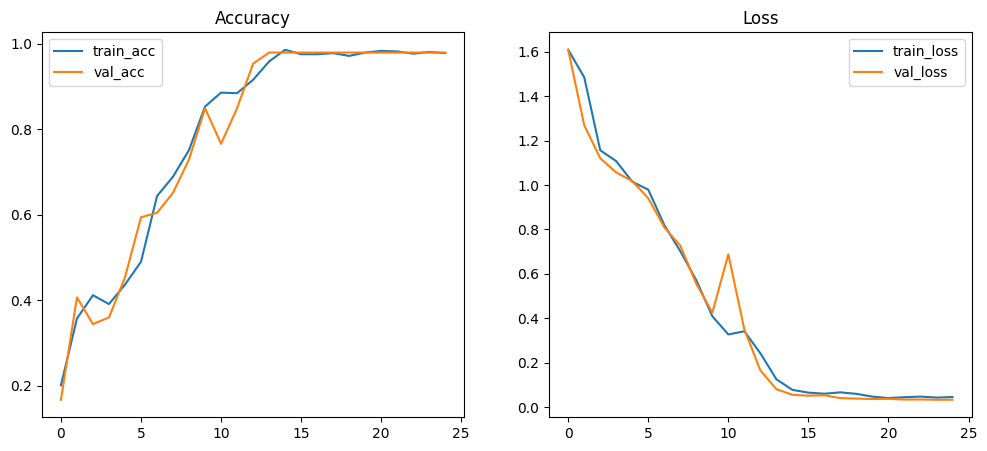

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Classification Report:

                 precision    recall  f1-score   support

Cloud Computing       1.00      1.00      1.00        48
  Cybersecurity       1.00      1.00      1.00        48
   Data Science       1.00      0.96      0.98        48
         DevOps       0.96      1.00      0.98        48
Web Development       1.00      1.00      1.00        48

       accuracy                           0.99       240
      macro avg       0.99      0.99      0.99       240
   weighted avg       0.99      0.99      0.99       240



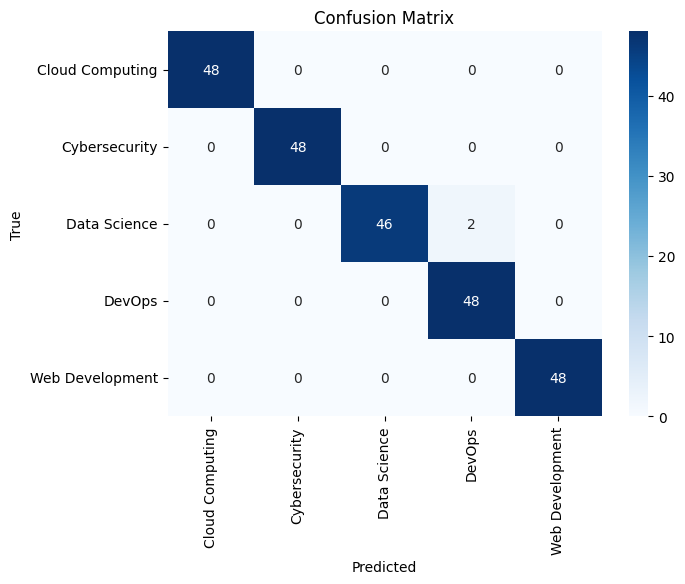

In [9]:


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#  12. Save Model


In [10]:

model.save("it_domain_lstm_glove_model.keras")
print("✅ Model saved as it_domain_lstm_glove_model.keras")

✅ Model saved as it_domain_lstm_glove_model.keras



# 13. Test single question


In [11]:

def predict_domain(question):
    cleaned = clean_text(question)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)
    domain = label_encoder.classes_[np.argmax(pred)]
    return domain

example = "What are the main layers in deep learning architectures?"
print(f"Predicted domain: {predict_domain(example)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted domain: Data Science
